In [2]:
!pip install patchify albumentations
!pip install -q -U segmentation-models
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [26]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow import keras
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
from patchify import patchify
import utils, utils_cityscapes as utils_cs
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss, cce_jaccard_loss
from segmentation_models.metrics import iou_score, f1_score, IOUScore, FScore
from segmentation_models.metrics import precision, recall

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Activation, Reshape, Convolution2D, BatchNormalization

In [5]:
DATA_DIR = '../input/massachusetts-buildings-dataset/tiff/'
PATCH_HEIGHT = 500
PATCH_WIDTH = 500

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')


In [10]:
# [0, 0, 0] -> background [255, 255, 255] -> Buldings

class_dict = pd.read_csv("../input/massachusetts-buildings-dataset/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'building']
# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]
Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [11]:
trainimg_dir, trainmsk_dir = utils.get_images_paths(x_train_dir, y_train_dir)
valimg_dir, valmsk_dir = utils.get_images_paths(x_valid_dir, y_valid_dir)
test_images_paths, test_masks_paths = utils.get_images_paths(x_test_dir, y_test_dir)

train_images, train_masks = utils.load_preprocess_images(trainimg_dir, trainmsk_dir, (PATCH_WIDTH, PATCH_HEIGHT), (256, 256), 2, class_rgb_values)
val_images, val_masks = utils.load_preprocess_images(valimg_dir, valmsk_dir, (PATCH_WIDTH, PATCH_HEIGHT), (256, 256), 2, class_rgb_values)


In [ ]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def tversky(y_true, y_pred, smooth=1, alpha=1):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred, alpha=1):
    return 1 - tversky(y_true, y_pred, alpha=alpha)


def focal_tversky_loss(y_true, y_pred, gamma=0.75, alpha=0.75):
    tv = tversky(y_true, y_pred, alpha=alpha)
    return K.pow((1 - tv), gamma)

In [23]:
def dilated(num_of_classes, input_shape):
    
    inputs = Input(shape=input_shape)
    # Front
    conv_1 = Convolution2D(64, (3,3), padding="same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (3,3), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    conv_3 = Convolution2D(128, (3,3), padding="same", dilation_rate=2)(conv_2)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (3,3), padding="same", dilation_rate=2)(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    conv_5 = Convolution2D(256, (3,3), padding="same", dilation_rate=3)(conv_4)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (3,3), padding="same", dilation_rate=3)(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Convolution2D(256, (3,3), padding="same", dilation_rate=3)(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)
    
    # LFE
    conv_8 = Convolution2D(128, (3,3), padding="same", dilation_rate=3)(conv_7)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Convolution2D(128, (3,3), padding="same", dilation_rate=3)(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Convolution2D(128, (3,3), padding="same", dilation_rate=3)(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    conv_11 = Convolution2D(128, (3,3), padding="same", dilation_rate=2)(conv_10)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Convolution2D(128, (3,3), padding="same", dilation_rate=2)(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Convolution2D(128, (3,3), padding="same")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)
    conv_14 = Convolution2D(128, (3,3), padding="same")(conv_13)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    
    # Head
    conv_15 = Convolution2D(256, (7,7), padding="same", dilation_rate=3)(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Convolution2D(256, (1,1), padding="same")(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)
    conv_17 = Convolution2D(num_of_classes, (1,1), padding="same")(conv_16)
    conv_17 = BatchNormalization()(conv_17)
    if num_of_classes==2:
        conv_17 = Activation("sigmoid")(conv_17)
    else:
        conv_17 = Activation("softmax")(conv_17)
    model = Model(inputs=inputs, outputs=conv_17, name="Dilated")

    return model

In [24]:
model = dilated(2, (256,256,3))

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=True, name="SGD")

model.compile(loss=bce_jaccard_loss, optimizer=optimizer, metrics=[iou_score, FScore(),tversky])
model.summary()

Model: "Dilated"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_153 (Bat (None, 256, 256, 64)      256       
_________________________________________________________________
activation_153 (Activation)  (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_154 (Bat (None, 256, 256, 64)      256       
_________________________________________________________________
activation_154 (Activation)  (None, 256, 256, 64)      0   

In [25]:
epochs=50
batch_size=2
model.fit(x=np.array(train_images),
        y=np.array(train_masks),
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(np.array(val_images), np.array(val_masks)),
)

NameError: name 'train_images' is not defined

In [ ]:
#model.save_weights('./' + "dilated_buildings.hdf5")
#print("save weight done..")

In [18]:
# save the model:
model.save(f'./dilated_buildings_{epochs}_{batch_size}.h5')

In [ ]:
# to load the model without doing again the training:
# model = keras.models.load_model('./dilated_buildings.hdf5')

In [ ]:
test_images_paths, test_masks_paths = utils.get_images_paths(x_test_dir, y_test_dir)
test_images, test_masks = utils.load_preprocess_images(test_images_paths, test_masks_paths, (PATCH_WIDTH, PATCH_HEIGHT), (256, 256), 2, class_rgb_values)
test_images = np.array(test_images)
test_masks = np.array(test_masks)

In [ ]:
#model_buildings_evaluation = model.evaluate(test_images, test_masks)

## CityScapes

In [33]:
DATA_DIR = '../input/cityscape/'

x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/annotations')

x_valid_dir = os.path.join(DATA_DIR, 'val/images')
y_valid_dir = os.path.join(DATA_DIR, 'val/annotations')

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/annotations')


class_values = utils_cs.grouped_labels
n_labels = len(class_values)+1
ACTIVATION = 'softmax'
BATCH_SIZE = 4
EPOCHS = 5

optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.1, momentum=0.9, nesterov=True, name="SGD")

model = dilated(num_of_classes=n_labels, input_shape=(256, 256, 3))

model.compile(optimizer=optimizer, loss=cce_jaccard_loss, metrics=[IOUScore(),FScore()] )

training_dataset = utils_cs.Dataset(x_train_dir, y_train_dir, class_values=class_values)
valid_dataset = utils_cs.Dataset(x_valid_dir, y_valid_dir, class_values=class_values)

train_dataloader = utils_cs.Dataloder(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = utils_cs.Dataloder(valid_dataset, batch_size=1, shuffle=False)
history = []

In [58]:
# train model
res = model.fit(
    train_dataloader, 
    epochs=5, 
    validation_data=valid_dataloader
)
history.append(res.history)

Epoch 1/5
287/287 [==============================] - 240s 836ms/step - loss: 0.5152 - iou_score: 0.5635 - f1-score: 0.6752 - val_loss: 0.7416 - val_iou_score: 0.4219 - val_f1-score: 0.5327
Epoch 2/5
287/287 [==============================] - 240s 834ms/step - loss: 0.4937 - iou_score: 0.5811 - f1-score: 0.6916 - val_loss: 0.7259 - val_iou_score: 0.4286 - val_f1-score: 0.5448
Epoch 3/5
287/287 [==============================] - 239s 833ms/step - loss: 0.4792 - iou_score: 0.5929 - f1-score: 0.7029 - val_loss: 0.8065 - val_iou_score: 0.4284 - val_f1-score: 0.5363
Epoch 4/5
287/287 [==============================] - 240s 834ms/step - loss: 0.4634 - iou_score: 0.6061 - f1-score: 0.7156 - val_loss: 0.8432 - val_iou_score: 0.3680 - val_f1-score: 0.4775
Epoch 5/5
287/287 [==============================] - 240s 835ms/step - loss: 0.4499 - iou_score: 0.6174 - f1-score: 0.7263 - val_loss: 0.7996 - val_iou_score: 0.4100 - val_f1-score: 0.5243


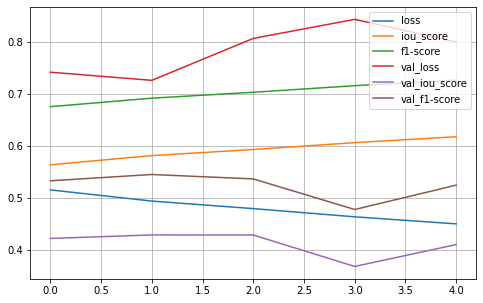

In [63]:
# print the graph
pd.DataFrame(history[1]).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [67]:
model.save(f'./dilated_cityscape_{epochs}_{batch_size}.h5')
#model.load_weights(f'./dilated_cityscape_{epochs}_{batch_size}.h5')

In [68]:
test_dataset = utils_cs.Dataset(x_test_dir, y_test_dir, class_values=class_values)
test_dataloader = utils_cs.Dataloder(test_dataset, batch_size=1, shuffle=False)

In [ ]:
model.evaluate(test_dataloader)

In [69]:
pred = model.predict(test_dataloader)
result = np.argmax(pred,axis=3)

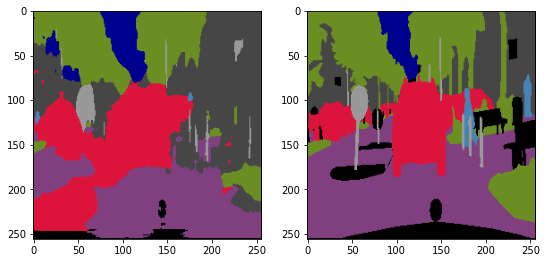

In [71]:
res_seg = utils_cs.colour_code_segmentation(result[2]) #colour the mask by using the dictionary, group_label -> pixel

mask_example = test_dataset.__getitem__(2)[1]
mask_example = test_dataset.convert_to_single_mask(mask_example) 
result_example = utils_cs.colour_code_segmentation(mask_example)

fig, axes = plt.subplots(1, 2,figsize=(9,6))
_ = axes[0].imshow(res_seg)
_ = axes[1].imshow(result_example)
plt.show()